# Train autoregressive model using RNN, LSTM, GRU (unidirectional) - on multi_window

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display

### Fetch the Data

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [37]:
dataset = pd.read_csv(csv_path)
dataset = dataset[5::6]

In [38]:
dataset.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [39]:
#Convert the format of date and time
date_time = pd.to_datetime(dataset.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [40]:
wv = dataset['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

In [41]:
max_wv = dataset['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

#### These inplace edits are reflected in the DataFrame

In [42]:
dataset['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

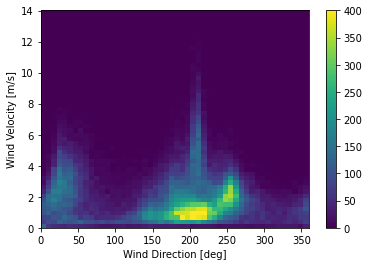

In [43]:
plt.hist2d(dataset['wd (deg)'], dataset['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [44]:
wv = dataset.pop('wv (m/s)')
print(wv)


5         0.21
11        0.25
17        0.18
23        0.10
29        0.40
          ... 
420521    0.87
420527    1.02
420533    0.71
420539    0.35
420545    0.56
Name: wv (m/s), Length: 70091, dtype: float64


In [45]:
max_wv = dataset.pop('max. wv (m/s)')
max_wv

5         0.63
11        0.63
17        0.63
23        0.38
29        0.88
          ... 
420521    1.36
420527    1.92
420533    1.56
420539    0.68
420545    1.00
Name: max. wv (m/s), Length: 70091, dtype: float64

In [46]:
wd_rad = dataset.pop('wd (deg)')*np.pi / 180     # Convert to radians
wd_rad

5         3.363249
11        3.321362
17        2.918191
23        4.188790
29        2.740167
            ...   
420521    3.326598
420527    3.933972
420533    2.769838
420539    3.782128
420545    3.536037
Name: wd (deg), Length: 70091, dtype: float64

In [47]:
# Calculate the wind x and y components.
dataset['Wx'] = wv*np.cos(wd_rad)
dataset['Wy'] = wv*np.sin(wd_rad)

In [48]:
# Calculate the max wind x and y components.
dataset['max Wx'] = max_wv*np.cos(wd_rad)
dataset['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

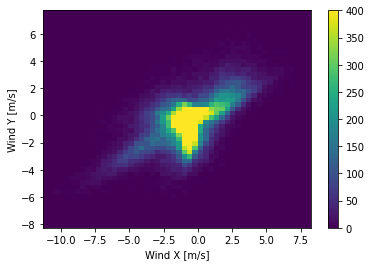

In [49]:
plt.hist2d(dataset['Wx'], dataset['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [50]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [51]:
day = 24*60*60
year = (365.2425)*day

In [52]:
dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

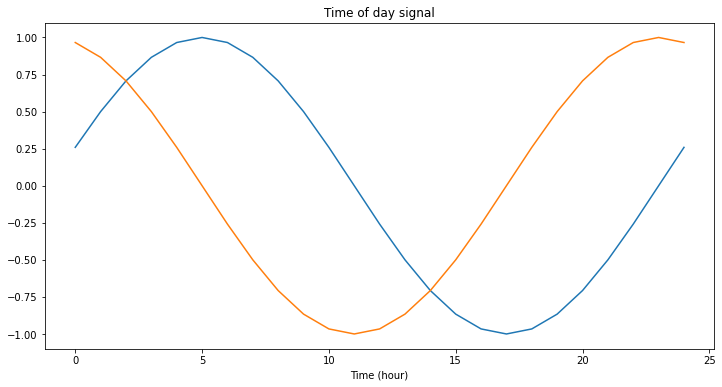

In [53]:
plt.figure(figsize=(12,6))
plt.plot(np.array(dataset['Day sin'])[:25])
plt.plot(np.array(dataset['Day cos'])[:25])
plt.xlabel('Time (hour)')
plt.title('Time of day signal')

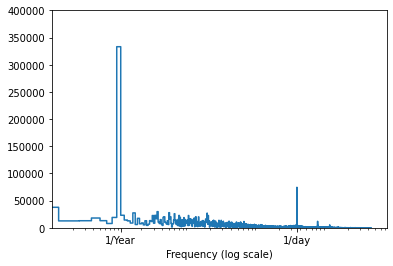

In [54]:
fft = tf.signal.rfft(dataset['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(dataset['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Splitting the data into test, validation and test set

In [55]:
column_indices = {name: i for i, name in enumerate(dataset.columns)}

n = len(dataset)
train_df = dataset[0:int(n*0.7)]
val_df = dataset[int(n*0.7):int(n*0.9)]
test_df = dataset[int(n*0.9):]

num_features = dataset.shape[1]

### Normalizing the data

In [56]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

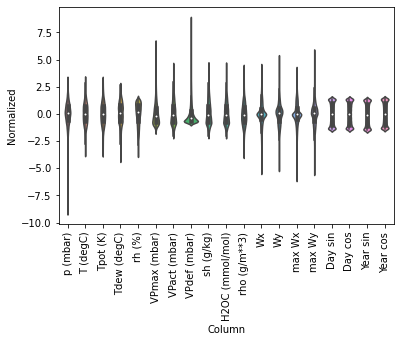

In [57]:
df_std = (dataset - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dataset.keys(), rotation=90)

In [58]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [59]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [60]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [61]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [62]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [63]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

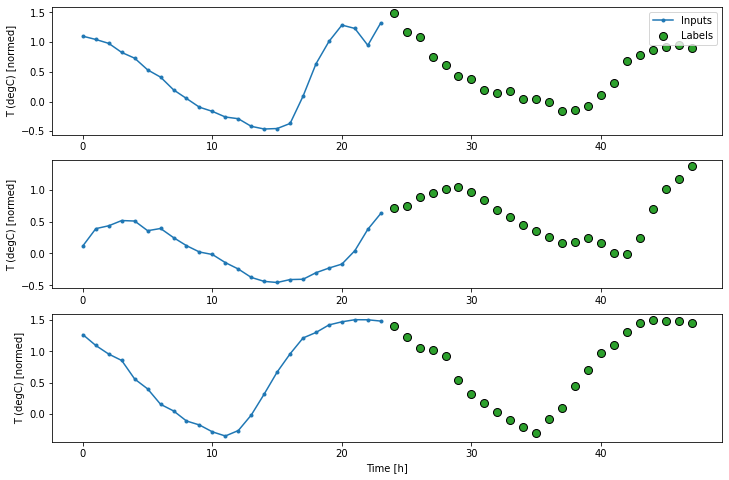

In [64]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Model Building

### LSTM Model

In [65]:
ms_lstm = tf.keras.Sequential([
                               tf.keras.layers.LSTM(32, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_lstm = compile_and_fit(ms_lstm, multi_window )

Epoch 1/20
1532/1532 [==============================] - 22s 14ms/step - loss: 0.2939 - mean_absolute_error: 0.3646 - val_loss: 0.2311 - val_mean_absolute_error: 0.3069
Epoch 2/20
1532/1532 [==============================] - 22s 15ms/step - loss: 0.2165 - mean_absolute_error: 0.2937 - val_loss: 0.2211 - val_mean_absolute_error: 0.2941
Epoch 3/20
1532/1532 [==============================] - 23s 15ms/step - loss: 0.2086 - mean_absolute_error: 0.2846 - val_loss: 0.2167 - val_mean_absolute_error: 0.2887
Epoch 4/20
1532/1532 [==============================] - 22s 14ms/step - loss: 0.2045 - mean_absolute_error: 0.2803 - val_loss: 0.2156 - val_mean_absolute_error: 0.2865
Epoch 5/20
1532/1532 [==============================] - 22s 14ms/step - loss: 0.2018 - mean_absolute_error: 0.2777 - val_loss: 0.2149 - val_mean_absolute_error: 0.2856
Epoch 6/20
1532/1532 [==============================] - 22s 14ms/step - loss: 0.1995 - mean_absolute_error: 0.2758 - val_loss: 0.2143 - val_mean_absolute_error:

### RNN Model

In [33]:
ms_rnn  = tf.keras.Sequential([
                               tf.keras.layers.SimpleRNN(64, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_rnn = compile_and_fit(ms_rnn, multi_window )

Epoch 1/20
1532/1532 [==============================] - 13s 9ms/step - loss: 0.2671 - mean_absolute_error: 0.3387 - val_loss: 0.2344 - val_mean_absolute_error: 0.3029
Epoch 2/20
1532/1532 [==============================] - 13s 9ms/step - loss: 0.2216 - mean_absolute_error: 0.2936 - val_loss: 0.2232 - val_mean_absolute_error: 0.2920
Epoch 3/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.2148 - mean_absolute_error: 0.2862 - val_loss: 0.2206 - val_mean_absolute_error: 0.2894
Epoch 4/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.2117 - mean_absolute_error: 0.2831 - val_loss: 0.2187 - val_mean_absolute_error: 0.2871
Epoch 5/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.2094 - mean_absolute_error: 0.2808 - val_loss: 0.2175 - val_mean_absolute_error: 0.2860
Epoch 6/20
1532/1532 [==============================] - 13s 9ms/step - loss: 0.2077 - mean_absolute_error: 0.2790 - val_loss: 0.2163 - val_mean_absolute_error: 0.284

### GRU Model

In [34]:
ms_gru  = tf.keras.Sequential([
                               tf.keras.layers.GRU(64, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_gru = compile_and_fit(ms_gru, multi_window )

Epoch 1/20
1532/1532 [==============================] - 25s 16ms/step - loss: 0.2513 - mean_absolute_error: 0.3243 - val_loss: 0.2181 - val_mean_absolute_error: 0.2908
Epoch 2/20
1532/1532 [==============================] - 25s 16ms/step - loss: 0.2076 - mean_absolute_error: 0.2817 - val_loss: 0.2120 - val_mean_absolute_error: 0.2830
Epoch 3/20
1532/1532 [==============================] - 25s 16ms/step - loss: 0.2003 - mean_absolute_error: 0.2748 - val_loss: 0.2102 - val_mean_absolute_error: 0.2805
Epoch 4/20
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1955 - mean_absolute_error: 0.2710 - val_loss: 0.2106 - val_mean_absolute_error: 0.2808
Epoch 5/20
1532/1532 [==============================] - 25s 17ms/step - loss: 0.1916 - mean_absolute_error: 0.2684 - val_loss: 0.2106 - val_mean_absolute_error: 0.2808


The lowest validation mean absolute error was found to be 0.2805 that was achieved from the GRU Model